In [4]:
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # -1  to USE CPU
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

get_ipython().magic(u'matplotlib inline')

C:\Users\vivek kumar\AppData\Local\Temp\ipykernel_19012\1020300839.py:18: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic(u'matplotlib inline')


In [5]:
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    return new_image

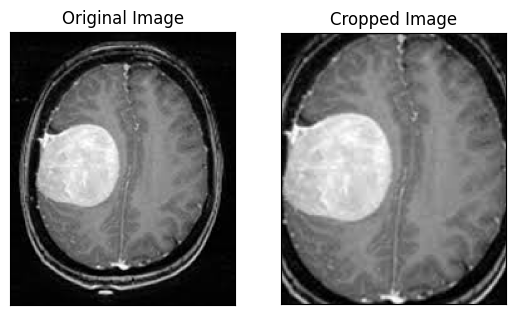

In [6]:
ex_img = cv2.imread('../DL dataset/yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [7]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    for directory in dir_list:
        for filename in listdir(directory):
            print(filename)
            print(directory)
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # print(image)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
    X = np.array(X)
    y = np.array(y)
    # Shuffle the data
    X, y = shuffle(X, y)
    print('Number of examples is:{}'.format(len(X)))
    return X,y

In [9]:
augmented_path = '../augmented data/'
# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

aug_Y100_0_2052.jpg
../augmented data/yes
aug_Y100_0_4855.jpg
../augmented data/yes
aug_Y100_0_5724.jpg
../augmented data/yes
aug_Y100_0_7447.jpg
../augmented data/yes
aug_Y100_0_8282.jpg
../augmented data/yes
aug_Y100_0_8493.jpg
../augmented data/yes
aug_Y100_0_9772.jpg
../augmented data/yes
aug_Y101_0_1228.jpg
../augmented data/yes
aug_Y101_0_2073.jpg
../augmented data/yes
aug_Y101_0_2175.jpg
../augmented data/yes
aug_Y101_0_236.jpg
../augmented data/yes
aug_Y101_0_3623.jpg
../augmented data/yes
aug_Y101_0_377.jpg
../augmented data/yes
aug_Y101_0_639.jpg
../augmented data/yes
aug_Y102_0_2156.jpg
../augmented data/yes
aug_Y102_0_3992.jpg
../augmented data/yes
aug_Y102_0_4385.jpg
../augmented data/yes
aug_Y102_0_5952.jpg
../augmented data/yes
aug_Y102_0_616.jpg
../augmented data/yes
aug_Y102_0_6866.jpg
../augmented data/yes
aug_Y102_0_8273.jpg
../augmented data/yes
aug_Y103_0_2659.jpg
../augmented data/yes
aug_Y103_0_3047.jpg
../augmented data/yes
aug_Y103_0_3473.jpg
../augmented data/

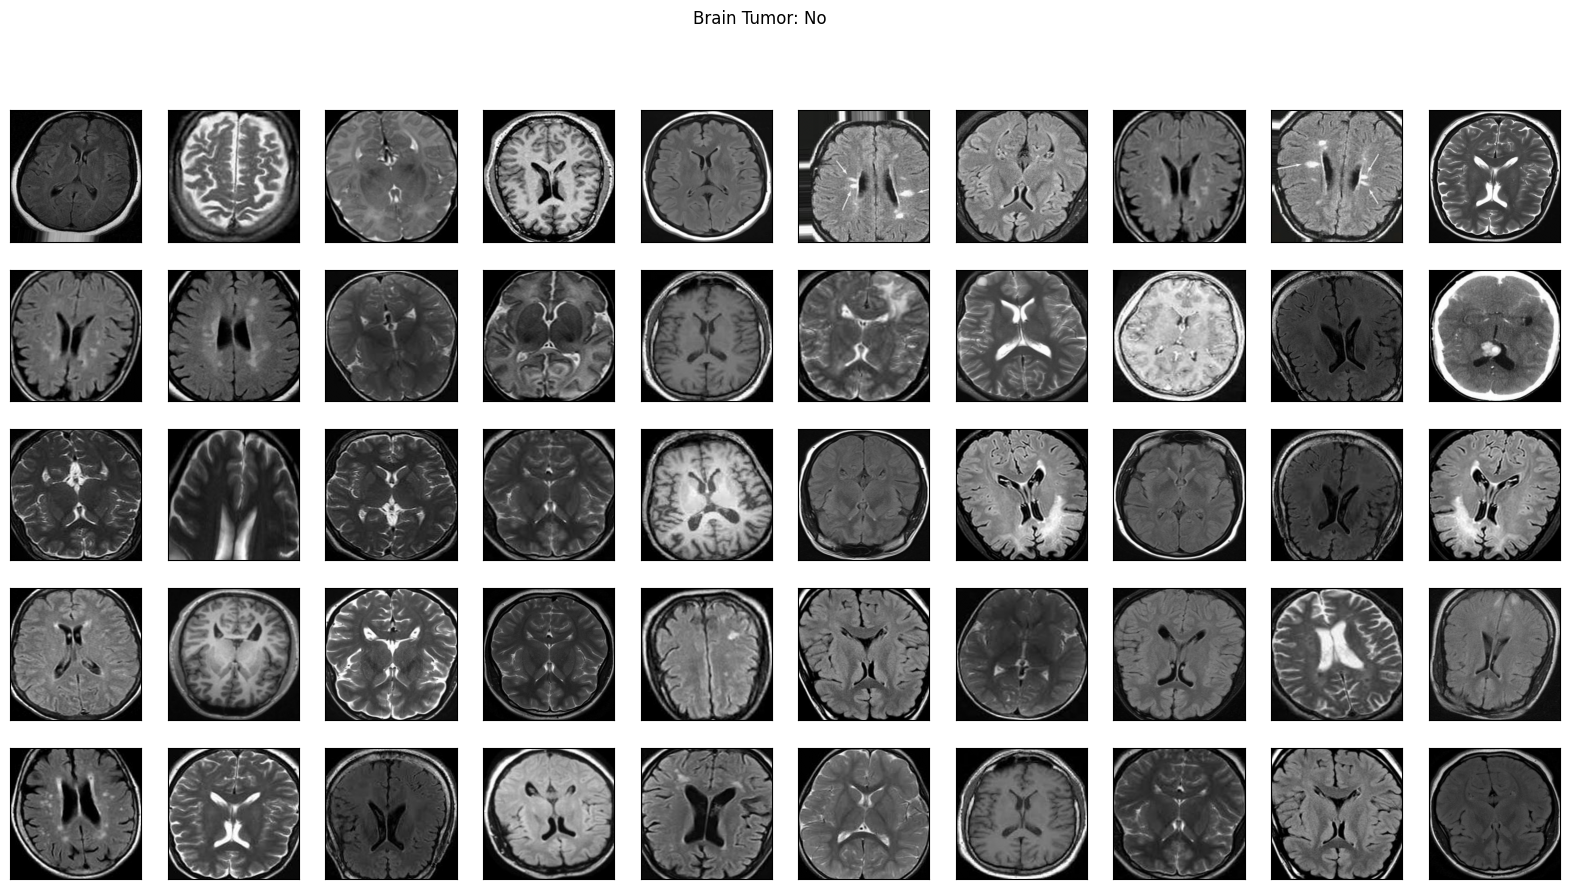

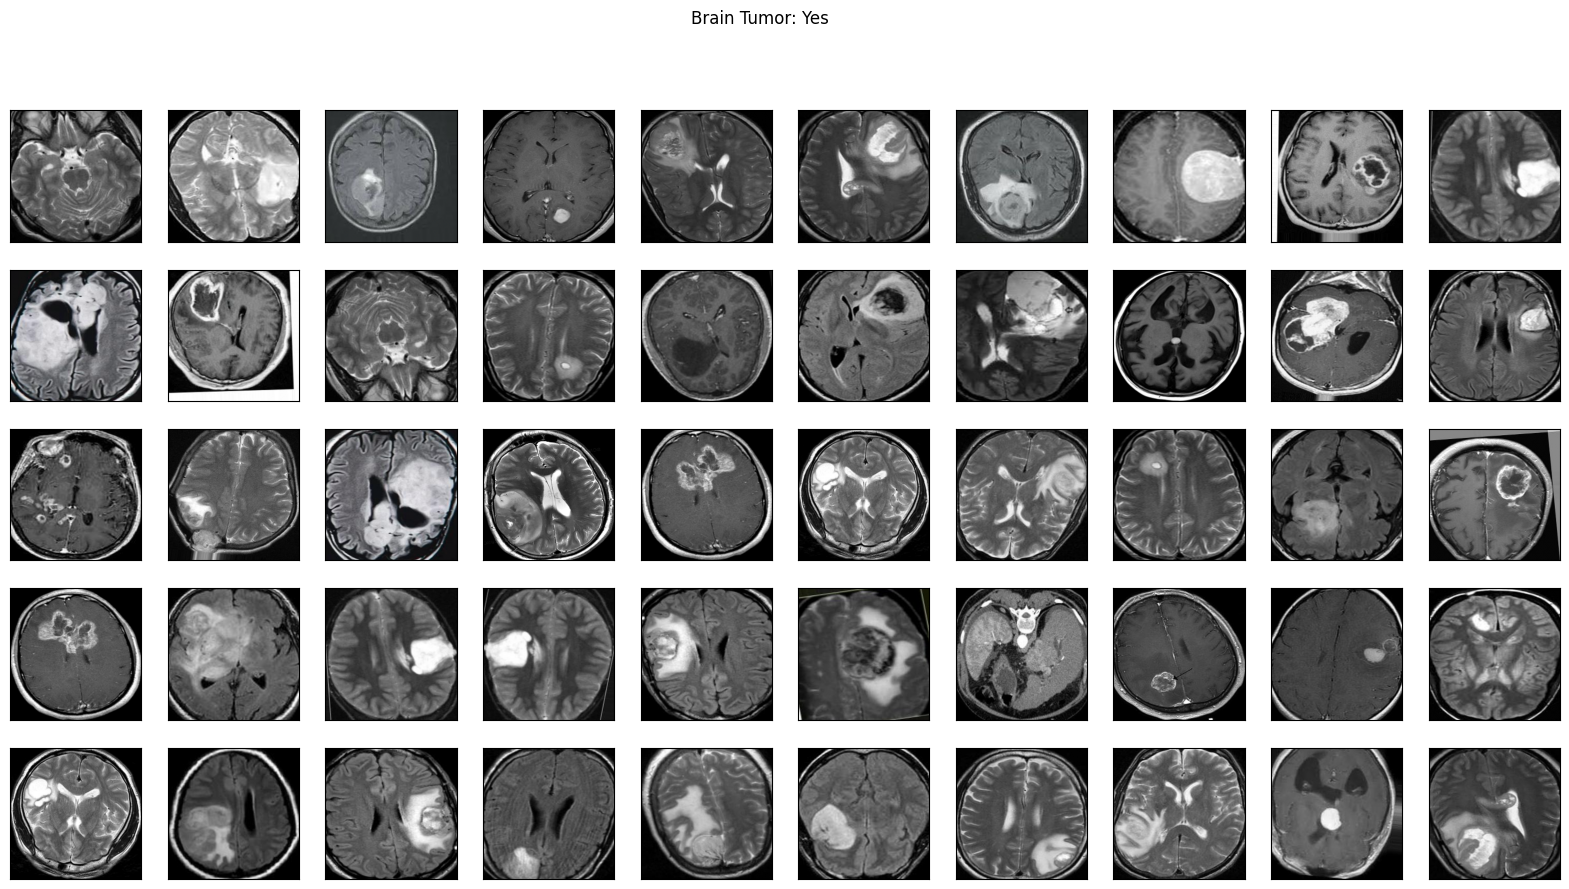

In [10]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle("Brain Tumor: {}".format(label_to_str(label)))
        plt.show()

plot_sample_images(X, y)

In [11]:
def split_data(X, y, test_size=0.2):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [13]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [14]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{}:{}".format(h,m,round(s,1))

In [15]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    score = f1_score(y_true, y_pred)

    return score

In [16]:
def build_model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape)
    X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv0')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # 

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool0')(X) # 
    # X=Dropout(0.50)(X)


    X = Conv2D(128, (5, 5), strides=(2, 2), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn1')(X)
    X = Activation('relu')(X)  # shape=(?, 238, 238, 32)
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    X=Dropout(0.50)(X)

    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)


    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

    return model

In [17]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 119, 119, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 58, 58, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 58, 58, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 58, 58, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,577 (908.50 KB)

 Trainable params: 232,193 (907.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


import time

# tensorboard
log_file_name = 'brain_tumor_detection_cnn_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(log_file_name))




# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("Notebook/{}.keras".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

In [22]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [23]:
filepath = "Notebook/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

In [24]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), callbacks=[reduce_lr,tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print("Elapsed time: {}".format(hms_string(execution_time)))

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7227 - loss: 0.6425
Epoch 1: val_accuracy improved from -inf to 0.63226, saving model to Notebook/cnn-parameters-improvement-01-0.63.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.7228 - loss: 0.6416 - val_accuracy: 0.6323 - val_loss: 0.6501 - learning_rate: 0.0010
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7353 - loss: 0.7473
Epoch 2: val_accuracy did not improve from 0.63226
46/46 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7354 - loss: 0.7475 - val_accuracy: 0.5581 - val_loss: 1.1392 - learning_rate: 0.0010
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7877 - loss: 0.5879
Epoch 3: val_accuracy did not improve from 0.63226
46/46 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.7880 - loss: 0.5863 - val_accuracy: 0.6290 - val_loss: 0.6099 - learning_rate: 0.0010
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8398 - loss: 0.3856
Epoch 4: val_accuracy did n

In [25]:
history = model.history.history

for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss
learning_rate


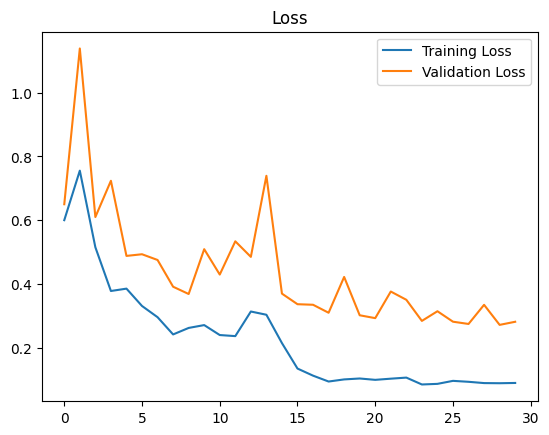

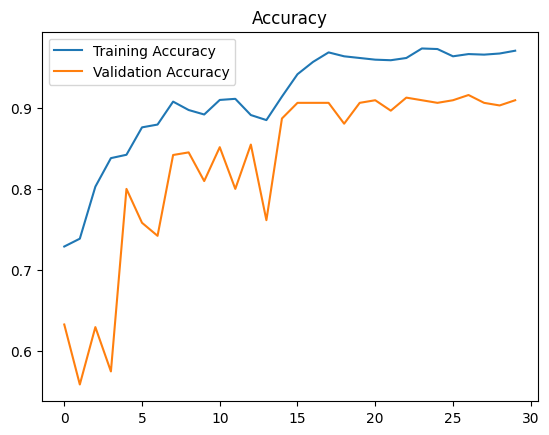

In [27]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()




plot_metrics(history)

In [28]:
model.metrics_names

['loss', 'compile_metrics']

In [29]:
loss, acc = model.evaluate(x=X_test, y=y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 475ms/step - accuracy: 0.8964 - loss: 0.3314


In [30]:
print ("Test Loss = {}".format(loss))
print ("Test Accuracy = {}".format(acc))

Test Loss = 0.3087890148162842
Test Accuracy = 0.8999999761581421


In [31]:
y_test_prob = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 488ms/step


In [32]:
f1score = compute_f1_score(y_test, y_test_prob)

In [33]:
y_val_prob = model.predict(X_val)

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 595ms/step


In [34]:
f1score_val = compute_f1_score(y_val, y_val_prob)

In [35]:
def data_percentage(y):

    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive

    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m

    print("Number of examples:{}".format(m))
    print("Percentage of positive examples: {}%, number of pos examples: {}".format(pos_prec,n_positive))
    print("Percentage of negative examples: {}%, number of neg examples: {}".format(neg_prec,n_negative))

In [36]:
data_percentage(y)

Number of examples:2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [37]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples:1445
Percentage of positive examples: 52.17993079584775%, number of pos examples: 754
Percentage of negative examples: 47.82006920415225%, number of neg examples: 691
Validation Data:
Number of examples:310
Percentage of positive examples: 52.903225806451616%, number of pos examples: 164
Percentage of negative examples: 47.096774193548384%, number of neg examples: 146
Testing Data:
Number of examples:310
Percentage of positive examples: 53.87096774193548%, number of pos examples: 167
Percentage of negative examples: 46.12903225806452%, number of neg examples: 143


In [39]:
model.save('Notebook/Brain_tumor_pre.keras') 